In [ ]:
# download UC Merced Landuse classification dataset
!wget http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip

--2024-04-04 20:42:39--  http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
Resolving weegee.vision.ucmerced.edu (weegee.vision.ucmerced.edu)... 169.236.184.65
Connecting to weegee.vision.ucmerced.edu (weegee.vision.ucmerced.edu)|169.236.184.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 332468434 (317M) [application/zip]
Saving to: ‘UCMerced_LandUse.zip.3’

UCMerced_LandUse.zi 100%[===================>] 317.07M  30.1MB/s    in 11s     

2024-04-04 20:42:50 (28.9 MB/s) - ‘UCMerced_LandUse.zip.3’ saved [332468434/332468434]



In [227]:
%%capture
!unzip UCMerced_LandUse.zip

In [225]:
import numpy as np

import torch
import torch.nn as nn
from torch.autograd  import Variable
from torch.utils.data import DataLoader
import torch.optim as optim # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F # All functions that don't have any parameters
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.model_selection import train_test_split
from collections import Counter

# 1. Data Preparation

In [226]:
# convert data from tif to jpg; the current tf dataset from images function does not support tif files
import os
from PIL import Image
import glob

target_size = (96,96)
path = '/content/UCMerced_LandUse/Images'
for category in os.listdir(path):
    for filename in glob.glob(os.path.join(path,category)+"/*.tif"):
        im = Image.open(filename)
        im_resized = im.resize(target_size)
        rgb_im = im_resized.convert('RGB')
        rgb_im.save(filename.replace("tif", "jpg"), quality=100)
        os.remove(filename)



KeyboardInterrupt: 

In [ ]:
img_dir = '/content/UCMerced_LandUse/Images'
dataset = torchvision.datasets.ImageFolder(root = img_dir,
                                           transform = transforms.ToTensor(),
                                           loader = Image.open)

In [ ]:
args = {
    'lr': 0.0001,
    'device': 'cpu',
    'epochs': 10,
    'batch_size': 20
}


In [ ]:
batch_size = args['batch_size']
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)


In [ ]:
num_classes = len(np.unique(dataset.targets))
num_classes

21

# 2.Train and Test Splitting (images plot)

In [ ]:
###train test split
train_idxs, test_idxs = train_test_split(np.arange(len(dataset.targets)),test_size=0.2, stratify=dataset.targets)

In [ ]:
Counter([x[1] for x in np.array(dataset.imgs)[train_idxs]])

Counter({'20': 80,
         '7': 80,
         '16': 80,
         '9': 80,
         '5': 80,
         '6': 80,
         '14': 80,
         '1': 80,
         '17': 80,
         '13': 80,
         '8': 80,
         '10': 80,
         '2': 80,
         '18': 80,
         '3': 80,
         '15': 80,
         '0': 80,
         '12': 80,
         '4': 80,
         '19': 80,
         '11': 80})

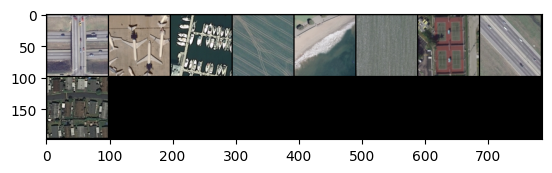

In [ ]:
###plot 9 images for illustration
import matplotlib.pyplot as plt
import numpy as np
import random

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(dataloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:9]))

In [ ]:
_, _, H, W = images.shape
images.shape

torch.Size([20, 3, 96, 96])

In [ ]:
###define the imagedataset class
class ImageDataset(torch.utils.data.Dataset):

    def __init__(self, dataset = None, sample_idxs = None, transform = None):

        # self.dataset = dataset
        self.sample_idxs = sample_idxs
        self.root = dataset.root
        self.data = np.array(dataset.imgs)[sample_idxs]
        self.targets = np.array(dataset.targets)[sample_idxs]
        self.transform = transform
        self.extensions = dataset.extensions
        self.class_to_idx = dataset.class_to_idx

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file, target_str = self.data[idx]
        target = self.targets[idx]
        assert target - int(target_str) == 0
        image = Image.open(file)
        if self.transform:
            image = self.transform(image)

        return image, target

# 3.Data Augmentation

In [ ]:
### data augmentation
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([

    transforms.RandomCrop(96), #Randomly crops the resized images
    transforms.RandomHorizontalFlip(p=0.5), #Randomly flips the images horizontally with a probability of 0.5
    transforms.RandomVerticalFlip(p=0.5),#Randomly flips the images vertically with a probability of 0.5
    transforms.RandomRotation(30),#Randomly rotates the images (-30-- 30) with a probability of 0.5
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
test_transform = transforms.Compose([

    transforms.CenterCrop(96),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [ ]:
### train test data loader
train_set = ImageDataset(dataset, sample_idxs = train_idxs, transform = train_transform)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

test_set = ImageDataset(dataset, sample_idxs = test_idxs, transform = test_transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

# 4.CNN

In [ ]:

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, in_dim = 3, out_classes = 21):
        super().__init__()

        self.in_dim = in_dim
        self.out_classes = out_classes

        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5, padding = 1)
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5, padding = 1)
        self.pool2 = nn.MaxPool2d(kernel_size = 3, stride = 3)
        self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 20, kernel_size = 6)
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(in_features = 20 * 5 * 5, out_features = 120)
        self.fc2 = nn.Linear(in_features = 120, out_features = 84)
        self.fc3 = nn.Linear(in_features = 84, out_features = out_classes)

    def forward(self, x):
        '''
        Args:
            x: shape (B, C = 3, H = 96, W = 96)
        '''
        # Padding = 1, Stride = 1, Dilation = 1
        # H and W: (96 + 2*1 - 1*(5-1) -1)/1 +1 = 94
        # x: shape (B, 6, 94, 94)
        x = F.relu(self.conv1(x))
        # padding=0,stride =2
        # H and W: (94 + 2*0 - 1*(2-1) -1)/2 +1 = 47
        # x: shape (B, 6, 47, 47)
        x = self.pool1(x)
        # H and W: (47 + 2*1 - 1*(5-1) -1)/1 +1 = 45
        # x: shape (B, 16, 45, 45)
        x = F.relu(self.conv2(x))
        # H and W: (45 + 2*0 - 1*(3-1) -1)/3 +1 = 15
        # x: shape (B, 16, 15, 15)
        x = self.pool2(x)
        # H and W: (15 + 2*1 - 1*(6-1) -1)/1 +1 = 10
        # x: shape (B, 20, 10, 10)
        x = F.relu(self.conv3(x))
        # x: shape (B,20, 5, 5)
        x = self.pool3(x)
        # x: shape (B, 20 * 5 * 5)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        # x: shape (B, 120)
        x = F.relu(self.fc1(x))
        # x: shape (B, 84)
        x = F.relu(self.fc2(x))
        # x: shape (B, 10)
        x = self.fc3(x)
        return x


net = Net()

In [ ]:
net


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 20, kernel_size=(6, 6), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=500, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=21, bias=True)
)

In [ ]:
### Define a loss function and the optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.00001)

In [ ]:
###
num_epochs = 3
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, (inputs,labels) in enumerate(trainloader):
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        print('Epoch [{}/{}], Batch [{}/{}], Loss: {:.8f}'.format(epoch+1, num_epochs, i, len(trainloader), loss.item()))

print('Finished Training')

Epoch [1/3], Batch [0/84], Loss: 1.25907063
Epoch [1/3], Batch [1/84], Loss: 1.41570830
Epoch [1/3], Batch [2/84], Loss: 2.03652120
Epoch [1/3], Batch [3/84], Loss: 1.45201242
Epoch [1/3], Batch [4/84], Loss: 1.06928337
Epoch [1/3], Batch [5/84], Loss: 0.98195189
Epoch [1/3], Batch [6/84], Loss: 1.39183855
Epoch [1/3], Batch [7/84], Loss: 1.67939723
Epoch [1/3], Batch [8/84], Loss: 1.21232772
Epoch [1/3], Batch [9/84], Loss: 1.18004477
Epoch [1/3], Batch [10/84], Loss: 1.35209131
Epoch [1/3], Batch [11/84], Loss: 1.33105993
Epoch [1/3], Batch [12/84], Loss: 1.66039824
Epoch [1/3], Batch [13/84], Loss: 1.10077548
Epoch [1/3], Batch [14/84], Loss: 1.50758994
Epoch [1/3], Batch [15/84], Loss: 1.29172289
Epoch [1/3], Batch [16/84], Loss: 1.70603371
Epoch [1/3], Batch [17/84], Loss: 1.56728709
Epoch [1/3], Batch [18/84], Loss: 1.38226950
Epoch [1/3], Batch [19/84], Loss: 1.83632851
Epoch [1/3], Batch [20/84], Loss: 1.15614104
Epoch [1/3], Batch [21/84], Loss: 1.56809568
Epoch [1/3], Batch [

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    net.eval()
    for inputs, labels in testloader:
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the %d test images: %.4f %%' % (len(test_set), 100 * correct / total))

Accuracy of the network on the 420 test images: 47.8571 %


In [ ]:
def test(testloader, net):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct *1.0/ total
    return accuracy

In [ ]:
acc = test(testloader, net)
print(f'Accuracy of the network on the test images: {100 * acc} %')

Accuracy of the network on the test images: 47.85714285714286 %


# 5.Transfer Learning (Inception V3)

In [ ]:
models.__dict__

{'__name__': 'torchvision.models',
 '__doc__': None,
 '__package__': 'torchvision.models',
 '__loader__': <_frozen_importlib_external.SourceFileLoader at 0x7cdab15e1cc0>,
 '__spec__': ModuleSpec(name='torchvision.models', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7cdab15e1cc0>, origin='/usr/local/lib/python3.10/dist-packages/torchvision/models/__init__.py', submodule_search_locations=['/usr/local/lib/python3.10/dist-packages/torchvision/models']),
 '__path__': ['/usr/local/lib/python3.10/dist-packages/torchvision/models'],
 '__file__': '/usr/local/lib/python3.10/dist-packages/torchvision/models/__init__.py',
 '__cached__': '/usr/local/lib/python3.10/dist-packages/torchvision/models/__pycache__/__init__.cpython-310.pyc',
 '__builtins__': {'__name__': 'builtins',
  '__doc__': "Built-in functions, exceptions, and other objects.\n\nNoteworthy: None is the `nil' object; Ellipsis represents `...' in slices.",
  '__package__': '',
  '__loader__': _frozen_importlib.Builti

In [ ]:
model = torchvision.models.inception_v3(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [ ]:
model.fc = nn.Linear(model.fc.weight.size(1), num_classes)
model.fc.weight.data.normal_(mean=0.0, std=0.01)
model.fc.bias.data.zero_()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
model.fc

Linear(in_features=2048, out_features=21, bias=True)

In [ ]:
print("Number of trainable parameters:", len(parameters))

Number of trainable parameters: 292


In [ ]:
## define loss function and optimizer
criterion = nn.CrossEntropyLoss()
# optimize only the linear classifier
parameters = list(filter(lambda p: p.requires_grad, model.parameters()))
optimizer = torch.optim.SGD(params = parameters,
                            lr = args['lr'],
                            momentum=0.9,
                            weight_decay=0.99)


In [ ]:
print("Number of trainable parameters:", len(parameters))

Number of trainable parameters: 292


In [ ]:
def test(testloader, model, device = 'cpu'):
    # evaluate on the whole dataset
    correct = 0
    total = 0
    model.eval()
    model = model.to(device)
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            # calculate outputs by running images through the network
            # outputs: shape (batch_size, num_classes)
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct *1.0/ total
    return accuracy

In [ ]:
def train(trainloader, model, optimizer, criterion, epoch, num_iter, device = "cpu"):
    model.train()
    model = model.to(device)
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        # inputs: shape (B, 3, 256, 256)
        # labels: shape (B)
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)


        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        # outputs: shape (B, 10)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        if i % 5 == 4:    # print loss every 500 mini-batches
            wandb.log({'num_iter': num_iter, 'train_loss': running_loss / 5})
            print(f'[{epoch}, {num_iter:5d}] loss: {running_loss / 5:.3f}')
            running_loss = 0.0

        # if i % 10 == 9:    # eval every 2000 mini-batches
        #     acc = test(testloader, model, device = args['device'])
        #     wandb.log({'num_iter': num_iter, "test_acc": acc})
        #     print(f'Test Accuracy: {100 * acc} %')

        num_iter += 1
    return model, num_iter

In [ ]:
!pip install wandb
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
### data augmentation
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize(299),
    transforms.RandomCrop(299), #Randomly crops the resized images
    transforms.RandomHorizontalFlip(p=0.5), #Randomly flips the images horizontally with a probability of 0.5
    transforms.RandomVerticalFlip(p=0.5),#Randomly flips the images vertically with a probability of 0.5
    transforms.RandomRotation(30),#Randomly rotates the images (-30-- 30) with a probability of 0.5
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
test_transform = transforms.Compose([
    transforms.Resize(299),
    transforms.RandomCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [ ]:
### train test data loader
train_set = ImageDataset(dataset, sample_idxs = train_idxs, transform = train_transform)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

test_set = ImageDataset(dataset, sample_idxs = test_idxs, transform = test_transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

In [ ]:
import wandb
wandb.login()
wandb.init(project="Lab2")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [ ]:
num_epochs = args['epochs']
num_iter = 0
for epoch in range(num_epochs):  # loop over the dataset multiple times
    model, num_iter = train(trainloader, model, optimizer, criterion, epoch, num_iter, device = args['device'])
    acc = test(testloader, model, device = args['device'])
    wandb.log({'num_iter': num_iter, "test_acc": acc})
    print(f'Test Accuracy: {100 * acc} %')